<a href="https://colab.research.google.com/github/Mael-zys/SD212/blob/main/lab7_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SD212: Graph mining
## Lab 7: Graph embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension.

In [ ]:
!pip install scikit-network

## Import

In [ ]:
from IPython.display import SVG

In [ ]:
import numpy as np
from scipy import sparse

In [ ]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral, BiSpectral
from sknetwork.linalg import HalkoEig
from sknetwork.ranking import top_k
from sknetwork.utils import KMeansDense
from sknetwork.visualization import svg_graph
import matplotlib.pyplot as plt


## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paristech.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [ ]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Unpacking archive...
Parsing files...
Done.
Unpacking archive...
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [ ]:
graph = karate_club(True)

In [ ]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

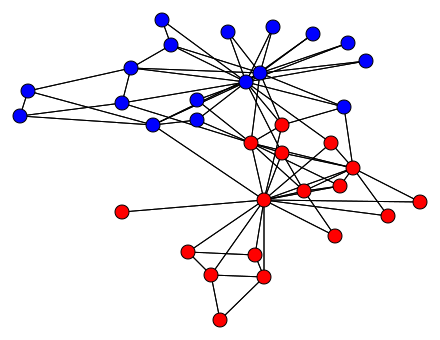

In [ ]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with the embedding in dimension 2.
* Check that the embedding weighted by the degrees is centered and that the components have the same variance.
* How many nodes are misclassified using the sign of the first eigenvector? What are these nodes?

In [ ]:
spectral = Spectral(20, normalized=False, regularization=None, scaling=0)

In [ ]:
spectral.fit(adjacency)

Spectral(n_components=20, regularization=None, relative_regularization=True, scaling=0, normalized=False, solver='auto')

In [ ]:
eigenvalues = spectral.eigenvalues_
print(eigenvalues)

[ 8.67727671e-01  7.12951015e-01  6.12686767e-01  3.87769460e-01
  3.51007053e-01  2.92791798e-01  2.60042011e-01  2.29089383e-01
  1.77057148e-01  1.35167055e-01  9.31839984e-02  1.68227430e-16
  6.27296373e-18  4.16798186e-33 -4.21715819e-36 -1.67864245e-34
 -2.16753698e-33 -3.44305505e-33 -1.06354076e-19 -1.08238377e-18]


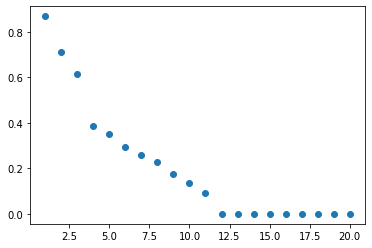

In [ ]:
plt.scatter(np.arange(20)+1,eigenvalues)

In [ ]:
embedding = spectral.embedding_

In [ ]:
X = embedding
X.shape

(34, 20)

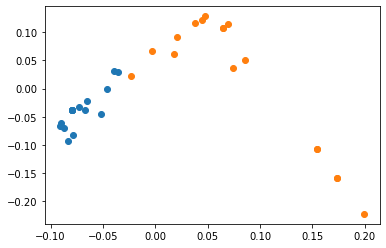

In [ ]:
for label in np.unique(labels_true):
  plt.scatter(X[labels_true==label,0], X[labels_true==label,1])

In [ ]:
pre = X[:,0]>0

In [ ]:
np.sum((pre!=labels_true))

2

In [ ]:
np.where(pre!=labels_true)

(array([2, 8]),)

## Openflights


We now consider a larger graph. We use the Laplacian eigenmap in dimension 20. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we work on the embedding in the unit sphere, which can be obtained through the parameter ``normalized`` of the class ``Spectral``.

In [ ]:
graph = openflights

In [ ]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

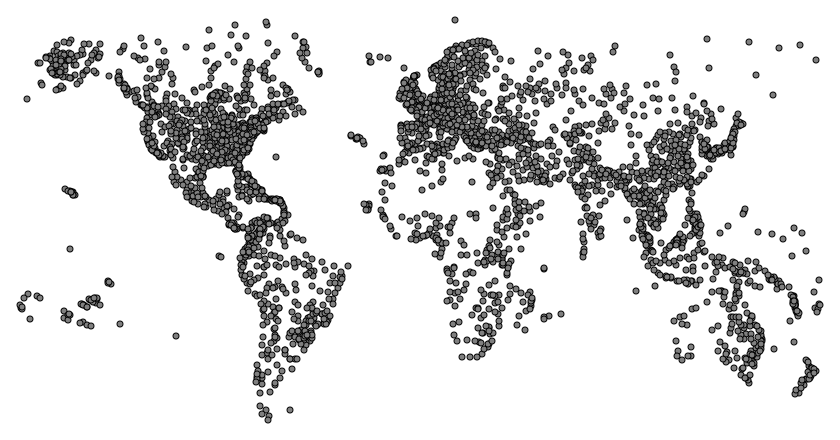

In [ ]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian.
* Display the same world map with the scores equal to the cosine similarity to **Beijing** in the embedding space.
* List the 10 closest airports to **Madrid** in terms of cosine similarity in the embedding space.
* Display the same world map with 8 clusters found by k-means in the embedding space (still using cosing similarity).

In [ ]:
spectral = Spectral(20, normalized=True, regularization=None, scaling=0)

In [ ]:
X = spectral.fit_transform(adjacency)
X.shape

(3097, 20)

In [ ]:
eigenvalues = spectral.eigenvalues_
print(eigenvalues)

[0.97249546 0.96295447 0.95712734 0.95113851 0.94038776 0.92916364
 0.90345955 0.89858245 0.89301727 0.88446894 0.87875717 0.86415475
 0.84869725 0.8362079  0.79690238 0.75519618 0.69383119 0.64159564
 0.60332009 0.53815761]


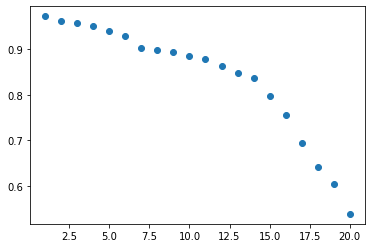

In [ ]:
plt.scatter(np.arange(20)+1,eigenvalues)

In [ ]:
np.linalg.norm(X,axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
beijing = 1618

In [ ]:
scores = X.dot(X[beijing])

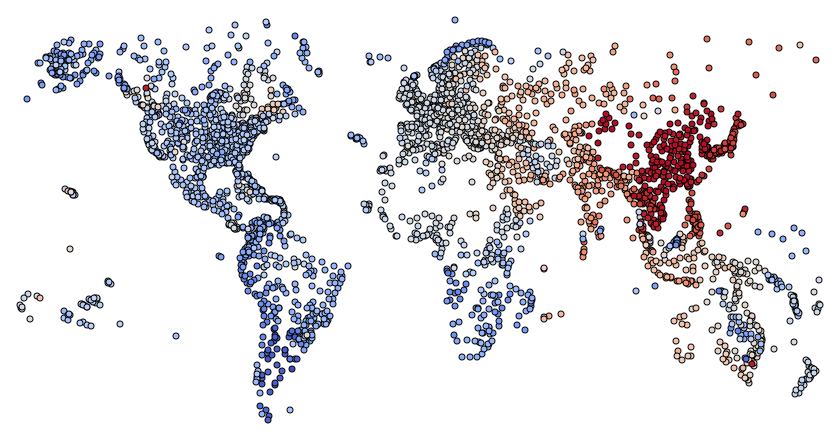

In [ ]:
image = svg_graph(adjacency, position, scores=scores, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

In [ ]:
madrid = 572

In [ ]:
scores = X.dot(X[madrid])

In [ ]:
top = top_k(scores,10)

In [ ]:
names[top]

array(['Adolfo Suárez Madrid–Barajas Airport',
       'Logroño-Agoncillo Airport', 'Pamplona Airport',
       'San Sebastian Airport', 'Badajoz Airport',
       'Tenerife Norte Airport', 'A Coruña Airport',
       'London Gatwick Airport', 'Amsterdam Airport Schiphol',
       'La Gomera Airport'], dtype='<U65')

In [ ]:
{i: name for i, name in enumerate(names) if 'Tokyo' in name}

{1084: 'Tokyo Haneda International Airport'}

In [ ]:
tokyo = 1084

In [ ]:
scores = X.dot(X[tokyo])

In [ ]:
top = top_k(scores,5)

In [ ]:
for t in top:
  print(names[t])

Tokyo Haneda International Airport
Oita Airport
Miho Yonago Airport
New Chitose Airport
Kushiro Airport


In [ ]:
from scipy.spatial.distance import cosine
distance = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    distance[i] = cosine(X[tokyo], X[i])

for i, idx in enumerate(top_k(-distance, 5)):
    print('%d: %s' %(i, names[idx]))

0: Tokyo Haneda International Airport
1: Oita Airport
2: Miho Yonago Airport
3: New Chitose Airport
4: Kushiro Airport


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
distance = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    distance[i] = cosine_similarity(np.expand_dims(X[tokyo], 0),  np.expand_dims(X[i], 0))

for i, idx in enumerate(top_k(distance, 5)):
    print('%d: %s' %(i, names[idx]))

0: Tokyo Haneda International Airport
1: Oita Airport
2: Miho Yonago Airport
3: New Chitose Airport
4: Kushiro Airport


## 2. Directed graphs

## Wikipedia Vitals

We now consider a large directed graph. We use the class ``BiSpectral`` (i.e., the directed graph is viewed as a bipartite graph).

In [ ]:
graph = wikivitals

In [ ]:
adjacency = graph.adjacency
names = graph.names
labels = graph.labels_hierarchy
names_labels = graph.names_labels_hierarchy

## To do

* Check that the average cosine similarity between all node pairs in some set $S$ is given by the square norm of the barycenter of $S$.
* Give the average cosine similarity between nodes in the **Mammals** category.
* Compare with the expected cosine similarity between two nodes sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is high, give the most topical category and the less topical category among all categories having at least 10 articles. 

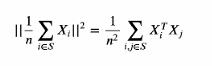

In [ ]:
spectral = BiSpectral(20, solver=HalkoEig(random_state=42), regularization=None, scaling=0)

In [ ]:
mammal = 274

In [ ]:
names_labels[mammal]

'Biology and health sciences.Organisms.Animals.Mammals'

In [ ]:
names[labels==mammal]

array(['Mammal', 'Aardvark', 'Armadillo', 'Hyrax', 'Pangolin', 'Sirenia',
       'Bat', 'Megabat', 'Microbat', 'Pteropus', 'Vampire bat',
       'Carnivora', 'Bear', 'Canidae', 'Felidae', 'Hyena', 'Mongoose',
       'Mustelidae', 'Procyonidae', 'Skunk', 'Cetacea', 'Whale',
       'Blue whale', 'Dolphin', 'Humpback whale', 'Killer whale',
       'Porpoise', 'Sperm whale', 'Hedgehog', 'Even-toed ungulate',
       'Alpaca', 'Wild boar', 'Bovidae', 'Camel', 'Deer', 'Llama',
       'Giraffe', 'Guanaco', 'Hippopotamus', 'Peccary', 'Domestic pig',
       'Pronghorn', 'Vicuña', 'Lagomorpha', 'Hare', 'Rabbit', 'Marsupial',
       'Diprotodontia', 'Dasyuromorphia', 'Opossum', 'Peramelemorphia',
       'Monotreme', 'Echidna', 'Platypus', 'Odd-toed ungulate', 'Donkey',
       'Equidae', 'Horse', 'Rhinoceros', 'Tapir', 'Zebra', 'Anteater',
       'Sloth', 'Pinniped', 'Eared seal', 'Earless seal', 'Walrus',
       'Primate', 'Monkey', 'Ape', 'New World monkey', 'Old World monkey',
       'Strepsirrh

In [ ]:
spectral.fit(adjacency)

BiSpectral(n_components=20, regularization=None, relative_regularization=True, scaling=0, normalized=True, solver=HalkoEig(which='LM', n_oversamples=10, n_iter='auto', power_iteration_normalizer='auto', one_pass=False))

In [ ]:
X = spectral.embedding_

In [ ]:
X.shape

(10012, 20)

In [ ]:
X = (X.T / np.linalg.norm(X, axis=1)).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
np.linalg.norm(np.mean(X[labels == mammal],axis=0))**2

0.8430373629438049

## 3. Bipartite graphs

Finally, we consider the co-embedding of each part of a bipartite graph. We focus on the bipartite graph formed by words used in the summaries of the articles of Wikivitals. 

## Wikipedia Vitals

In [ ]:
graph = wikivitals

In [ ]:
biadjacency = graph.biadjacency
articles = graph.names_row
words = graph.names_col

In [ ]:
biadjacency

<10012x31323 sparse matrix of type '<class 'numpy.int64'>'
	with 995919 stored elements in Compressed Sparse Row format>

In [ ]:
names[2000]

'Allergy'

In [ ]:
words[biadjacency.indices[biadjacency.indptr[2000]:biadjacency.indptr[2001]]]

array(['intoler', 'larger', 'allergen', 'known', 'epinephrin', 'test',
       'environ', 'affect', 'metal', 'may', 'also', 'receptor', 'least',
       'amount', 'use', 'due', 'inflammatori', 'person', 'von', 'common',
       'poison', 'antihistamin', 'hay', 'adrenalin', 'world', 'problem',
       'immunoglobulin', 'atop', 'cell', 'insect', 'genet', 'depend',
       'histamin', 'immunotherapi', 'sting', 'bite', 'case', 'system',
       'allerg', 'increas', 'environment', 'recommend', 'protect',
       'treatment', 'medic', 'e', 'ige', 'dermat', 'rash', 'howev',
       'food', 'antibodi', 'basophil', 'hypersensit', 'releas', 'runni',
       'histori', 'time', 'condit', 'immun', 'sneez', 'skin', 'develop',
       'nose', 'caus', 'rate', 'anaphylaxi', 'includ', 'word', 'sever',
       'diseas', 'typic', 'point', 'separ', 'bodi', 'swell', 'allergi',
       'signific', 'substanc', 'symptom', 'trigger', 'reaction', 'eye',
       'mast', 'blood', 'part', 'short', 'appear', 'first', 'red',
    

## To do

* What are now the most topical category and the less topical category among all categories having at least 10 articles?
* List the 10 most topical words associated with the most topical category, among all words used at least 10 times in the whole dataset.

In [ ]:
spectral.fit(biadjacency)

BiSpectral(n_components=20, regularization=None, relative_regularization=True, scaling=0, normalized=True, solver=HalkoEig(which='LM', n_oversamples=10, n_iter='auto', power_iteration_normalizer='auto', one_pass=False))

In [ ]:
X = spectral.embedding_
Y = spectral.embedding_col_

In [ ]:
print(X.shape, Y.shape)

(10012, 20) (31323, 20)


In [ ]:
label, count = np.unique(labels, return_counts=True)

In [ ]:
print(label)

[   2    3    4 ... 1738 1739 1740]


In [ ]:
# most popular article
score_max = 0
ind_max = 0
for i, l in enumerate(label):
  if count[i] >= 10:
    x = X[labels==l]
    scores = x @ x.T
    n = scores.shape[0]
    avg = (np.sum(scores)-n) / (n*(n-1))
    if avg > score_max:
      score_max = avg
      ind_max = i

In [ ]:
popular_label = label[ind_max]

In [ ]:
subset = X[labels == popular_label]

In [ ]:
n = subset.shape[0]
inner_sim = np.zeros(n)
for i in range(n):
    inner_sim[i] = np.sum(subset.dot(subset[i]))

In [ ]:
articles_set = names[labels==popular_label]
articles_set[np.argmax(inner_sim)]

'Cristiano Ronaldo'